# <font color='lightblue'>Fraud Dataset Analysis</font>

# <font color='yellow'>Question</font>

How well can a model be trained to have the highest possible recall when working with the research dataset?

## <font color='lightgreen'>Process</font>

* Remove outliers using the IQR method
* Scale remaining data using StandardScaler
* Split into train/test with stratified sampling
* Use random oversampling, SMOTE oversampling, undersampling, and Tomek Links to create new training sets for the model
* Gridsearch using the new training data with RandomForest Classifier
* Identify best sampling method
* Identify and plot feature importances

## <font color='pink'>Problem areas</font>:

* Just under 99% recall is a great sign for the model, and SMOTE oversampling appears to work well on this data. but some data cleaning methods. MinMaxScaler() is likely more optimal to use given that no features have negative values, and XGBoost could be tried in place of a Random Forest Classifer. This would allow for faster cross-validation and testing, and more time to find better hyperparameters.

## Recall - 0.988939
## Accuracy - 0.996943
## F1 - 0.979569
## Precision - 0.970375

In [1]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
import kaggle

warnings.filterwarnings('ignore')

In [2]:
#read in data

kaggle.api.authenticate()
kaggle.api.dataset_download_files('dhanushnarayananr/credit-card-fraud', path='../data', unzip=True)
data = pd.read_csv('../data/card_transdata.csv')

data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [3]:
#check for NA and duplicate values

data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 68.7 MB


Text(0.5, 0, 'Is Fraud')

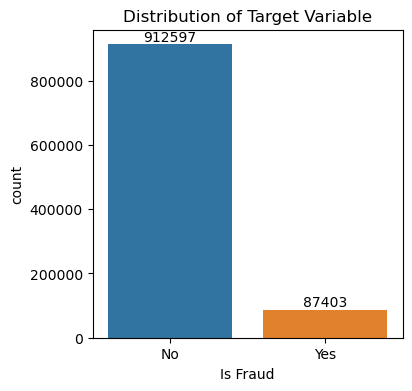

In [4]:
#plot target distributions

plt.figure(figsize=(4,4))

ax = sns.countplot(x=data['fraud'].map({0.0: 'No', 1.0: 'Yes'}), order=data['fraud'].map({0.0: 'No', 1.0: 'Yes'}).value_counts(ascending=False).index)
ax.set_title('Distribution of Target Variable')
ax.bar_label(container=ax.containers[0], labels=data['fraud'].map({0.0: 'No', 1.0: 'Yes'}).value_counts(ascending=False).values)
ax.set_xlabel('Is Fraud')

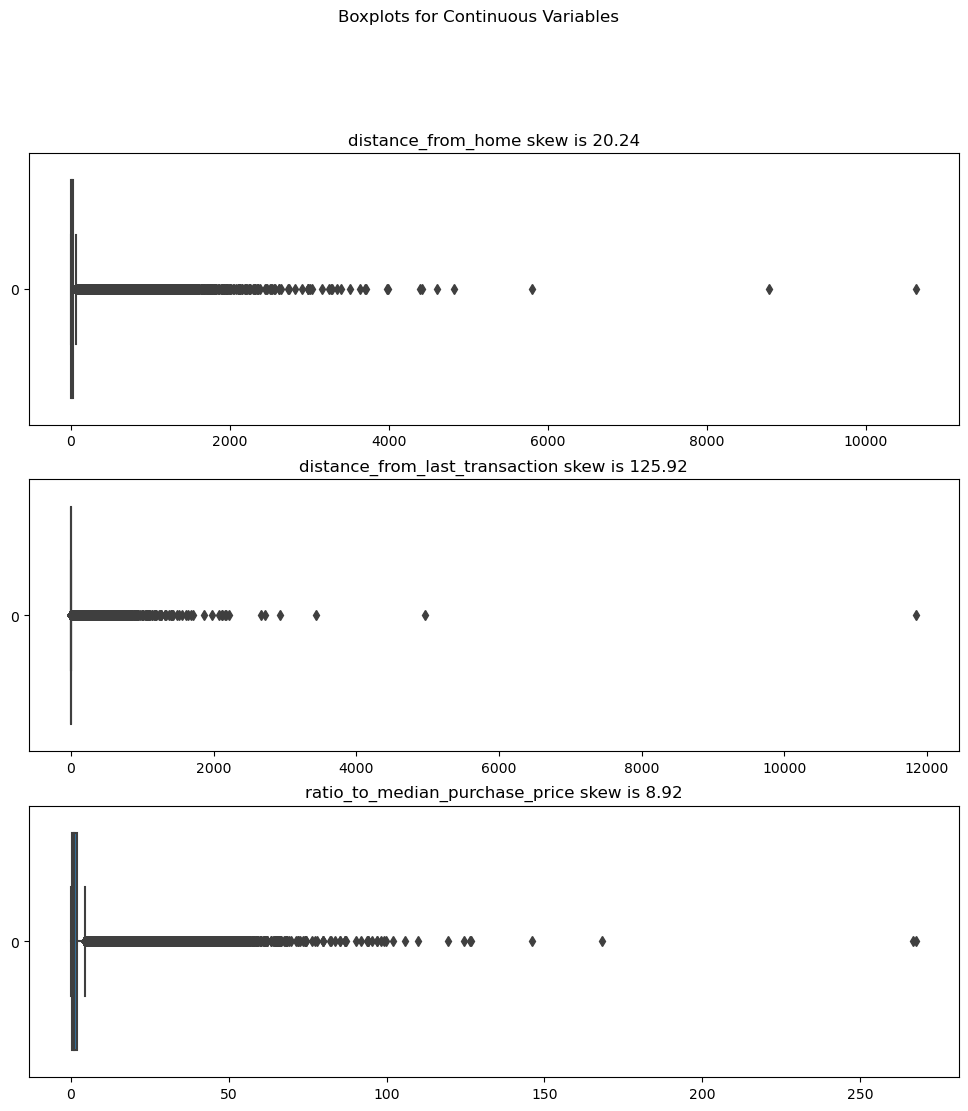

In [5]:
#boxplots of continuous variables and their skews

def create_boxplot(data, rows, columns):
    fig, axes = plt.subplots(nrows=rows, figsize=(12,12))
    fig.suptitle('Boxplots for Continuous Variables', y=1)
    for i, col in enumerate(columns):
        sns.boxplot(data=data[col], orient='h', ax=axes[i])
        axes[i].set_title(f'{col} skew is {str(round(data[col].skew(axis=0),2))}')


create_boxplot(data, 3, ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'])

In [6]:
#remove outliers via IQR method since data is so skewed

from collections import Counter

def IQR_method(data, cols):
    outliers = []
    for col in cols:
        Q1 = np.percentile(data[col], 25)
        Q3 = np.percentile(data[col], 75)
        IQR = Q3 - Q1
        outlier_range = IQR * 1.5

        outliers.extend(data[(data[col] < Q1 - outlier_range) | (data[col] > Q3 + outlier_range)].index)

    outliers = Counter(outliers)
    return [row for row, count in outliers.items() if count > 1]

data_cleaned = data.drop(IQR_method(data, ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']), axis=0).reset_index(drop=True)

Text(0.5, 0, 'Is Fraud')

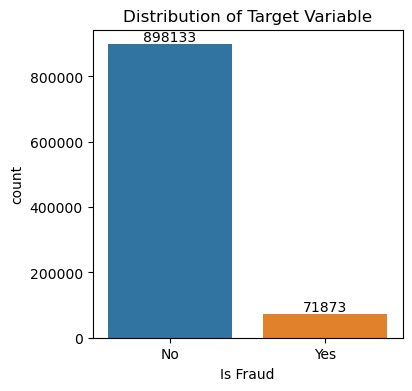

In [7]:
#new distribution of target variable after cleaning

plt.figure(figsize=(4,4))

ax = sns.countplot(x=data_cleaned['fraud'].map({0.0: 'No', 1.0: 'Yes'}), order=data_cleaned['fraud'].map({0.0: 'No', 1.0: 'Yes'}).value_counts(ascending=False).index)
ax.set_title('Distribution of Target Variable')
ax.bar_label(container=ax.containers[0], labels=data_cleaned['fraud'].map({0.0: 'No', 1.0: 'Yes'}).value_counts(ascending=False).values)
ax.set_xlabel('Is Fraud')

In [8]:
#split data using stratified sampling

X = data_cleaned.drop('fraud', axis=1)
y = data_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 8)

In [9]:
#scale data with StandardScaler

numeric_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
scaler = StandardScaler()
features = scaler.fit_transform(X_train[numeric_cols])
X_train[numeric_cols] = features

scaler = StandardScaler()
features = scaler.fit_transform(X_test[numeric_cols])
X_test[numeric_cols] = features

In [10]:
# STANDARD SAMPLING (NO CHANGE)
# Kfold cross val score test

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=5, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-1)

score = cross_val_score(clf, X_train, y_train, cv=kf, scoring='recall')
print(f'CV Recall Mean {score.mean()}')

CV Recall Mean 0.9998608665403796


In [11]:
#gridsearch hyperparams

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [4, 6, 8, 12]
}

grid_clf = GridSearchCV(clf, param_grid=params, cv=kf, scoring='recall', n_jobs=-2).fit(X_train, y_train)

print(f'Best params: {grid_clf.best_params_}')
print(f'Best score: {grid_clf.best_score_}')

Best params: {'max_depth': 12, 'n_estimators': 150}
Best score: 0.9998956491490754


In [12]:
#recreate hyperparams using best params from the gridsearch for future feature importances

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

clf = RandomForestClassifier(n_estimators=150, random_state=8, max_depth=12, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cm

array([[179197,    430],
       [   335,  14040]], dtype=int64)

<Axes: >

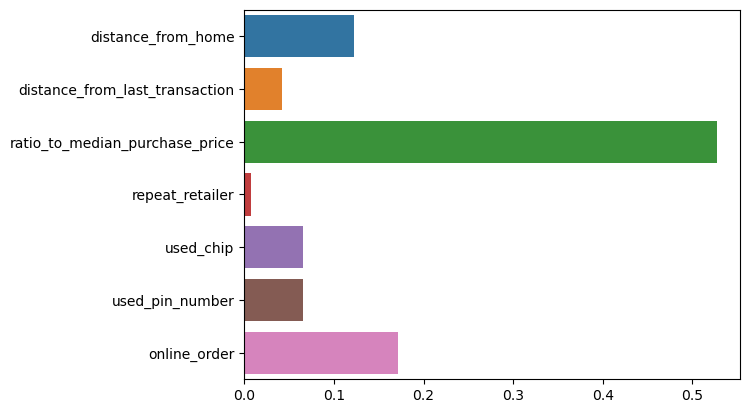

In [54]:
#feature importances from SMOTE

sns.barplot(x=clf.feature_importances_, y=X.columns)

In [13]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [14]:
# df of model scoring metrics

scores = pd.DataFrame([(recall, precision, f1, accuracy)], columns=['Recall','Precision','F1 Score', 'Accuracy'])

In [15]:
# OVERSAMPLING
#random oversampling

from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=8)

X_over, y_over = sampler.fit_resample(X_train, y_train)

In [42]:
#sampling counts

print(y_over.value_counts()[0], y_over.value_counts()[1])

#718506 per category is plenty of observations to run analysis on

718506 718506


In [16]:
from imblearn.pipeline import Pipeline, make_pipeline

pipeline = make_pipeline(RandomOverSampler(random_state=8), RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-1))

score = cross_val_score(pipeline, X_train, y_train, scoring='recall', cv=kf)
print(f'CV Recall Mean {score.mean()}')

CV Recall Mean 0.9999130404534231


In [18]:
#gridsearch

pipeline = make_pipeline(RandomOverSampler(random_state=8), RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-2))
over_params = {'randomforestclassifier__' + key: params[key] for key in params}
over_grid = GridSearchCV(pipeline, param_grid=over_params, cv=kf, scoring='recall', return_train_score=True)

over_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=8)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-2,
                                                               random_state=8))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 8, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             return_train_score=True, scoring='recall')

In [19]:
#best params

print(f'Best params: {over_grid.best_params_}')
print(f'Best score: {over_grid.best_score_}')

Best params: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 50}
Best score: 0.9999130404534231


In [24]:
#overfitting metrics

y_pred = over_grid.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

cm = confusion_matrix(y_test, y_pred)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

cm

array([[179193,    434],
       [   160,  14215]], dtype=int64)

<Axes: >

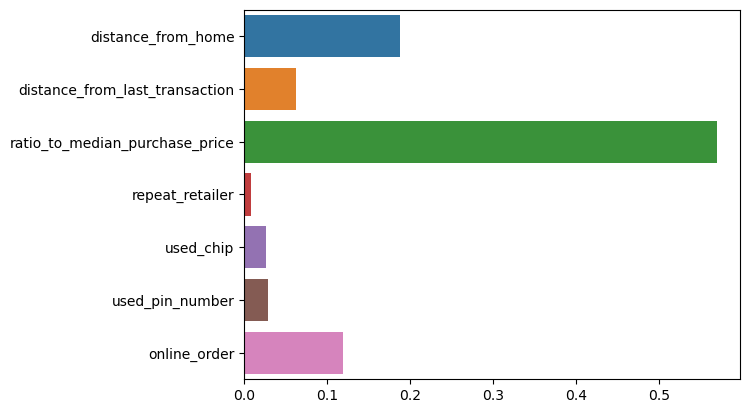

In [53]:
#feature importances from random overfitting

sns.barplot(x=over_grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_, y=X.columns)

In [38]:
#update scores df

scores.loc[-1] = [recall, precision, f1, accuracy]
scores.index = scores.index + 1
scores = scores.sort_index()

scores['method'] = ['No extra sampling', 'Random Oversampling']

scores

,Recall,Precision,F1 Score,Accuracy,method
0,0.988870,0.970373,0.979534,0.996938,No extra sampling
1,0.976696,0.970283,0.973479,0.996057,Random Oversampling


In [39]:
#RANDOM UNDERSAMPLING

from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=8)

X_under, y_under = sampler.fit_resample(X_train, y_train)

In [43]:
#undersampling dataset size

print(y_under.value_counts()[0], y_under.value_counts()[1])

#57498 is too small per category, as combined this makes up only roughly 10% of the dataset

57498 57498


In [44]:
#SMOTE (oversampling)

from imblearn.over_sampling import SMOTE

pipeline = make_pipeline(SMOTE(random_state=8), RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-2))

score = cross_val_score(pipeline, X_train, y_train, scoring='recall', cv=kf)
print(f'CV Recall Mean {score.mean()}')

CV Recall Mean 0.9998782563323086


In [45]:
#gridsearch for SMOTE

smote_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote_grid = GridSearchCV(pipeline, param_grid=smote_params, cv=kf, scoring='recall', return_train_score=True)
smote_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=8)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-2,
                                                               random_state=8))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 8, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             return_train_score=True, scoring='recall')

In [46]:
#best params for SMOTE

print(f'Best params: {smote_grid.best_params_}')
print(f'Best score: {smote_grid.best_score_}')

Best params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 100}
Best score: 0.9999130389410043


In [47]:
# SMOTE metrics

y_pred = smote_grid.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

cm = confusion_matrix(y_test, y_pred)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

cm

array([[179193,    434],
       [   159,  14216]], dtype=int64)

<Axes: >

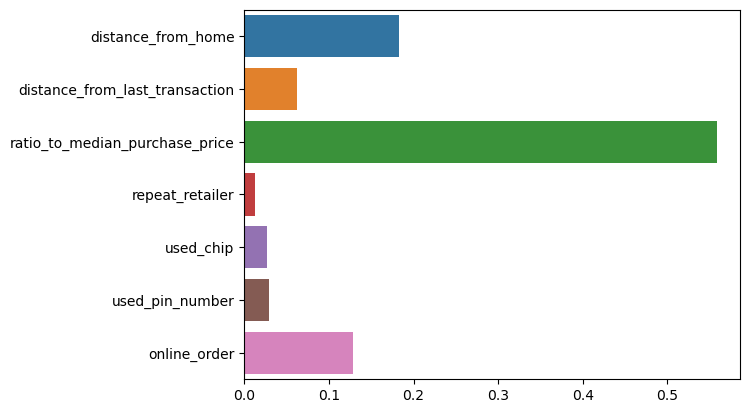

In [52]:
#feature importances from SMOTE

sns.barplot(x=smote_grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_, y=X.columns)

In [48]:
#update scores df

scores.loc[-1] = [recall, precision, f1, accuracy, 'SMOTE Oversampling']
scores.index = scores.index + 1
scores = scores.sort_index()

scores

,Recall,Precision,F1 Score,Accuracy,method
0,0.988939,0.970375,0.979569,0.996943,SMOTE Oversampling
1,0.988870,0.970373,0.979534,0.996938,No extra sampling
2,0.976696,0.970283,0.973479,0.996057,Random Oversampling


In [ ]:
#TOMEK LINKS

from imblearn.under_sampling import TomekLinks

tomek = TomekLinks()

X_under, y_under = tomek.fit_resample(X_train, y_train)

In [49]:
#TOMEK category sizes

print(y_under.value_counts()[0], y_under.value_counts()[1])

#a bit low, much like the other undersampling technique, so this will likely not be used

57498 57498


In [ ]:
#feature importances from 

sns.barplot(x=clf.feature_importances_, y=X.columns)

## <font color='purple'>Summary</font>

The model performs well, especially SMOTE oversampling. here are a few other ideas to try:

* transform data prior to employing outlier detection methods
* use less different outlier detection methods. (AOD, STD)
* use different models